In [34]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  


In [35]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision import transforms

In [36]:
from torch.utils.data import TensorDataset
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [37]:
class Trainer:

    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: None,
                 # lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 path2write: str = None,
                 save_best=False,
                 save_final=True,
                 save_interval=10,
                 checkpoint_start_epoch=50
                 ):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        # self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.path2write = path2write
        LOG_DIR = os.path.join(path2write, 'Log')  # path2write + 'Log/'
        self.writer_train = SummaryWriter(os.path.join(LOG_DIR, "train"))
        self.writer_val = SummaryWriter(os.path.join(LOG_DIR, "val"))
        self.check_point_path = os.path.join(path2write, 'check_points')
        if not os.path.exists(self.check_point_path):
            os.makedirs(self.check_point_path)
        self.save_best = save_best
        self.save_final = save_final
        self.save_interval = save_interval
        self.checkpoint_start_epoch = checkpoint_start_epoch
        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []
        self.training_accuracy = []
        self.validation_accuracy = []

    def run_trainer(self):
        self.model.to(self.device)
        #         print(next(self.model.parameters()).device)
        if self.notebook:
            print('Notebook')
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange
        #         print(self.epochs)
        progressbar = trange(self.epochs, desc='Progress', disable=True)  # don't show progressbar
        loss_max = None
        for epoch in progressbar:
            print(f'Epoch - {epoch}')

            # Training Block
            train_loss, train_accuracy = self._train()
            self.writer_train.add_scalar("Train Loss", train_loss, epoch)
            self.writer_train.add_scalar("Train Accuracy", train_accuracy, epoch)

            # Val Block
            val_loss, val_accuracy = self._validate()
            self.writer_val.add_scalar("Val Loss", val_loss, epoch)
            self.writer_val.add_scalar("Val Accuracy", val_accuracy, epoch)

            # lr
            self.writer_train.add_scalar("Learning Rate", self.optimizer.param_groups[0]['lr'], epoch)

            print(
                'Epoch - {} Train Loss - {:.6f} Val Loss - {:.6f} Train Accuracy - {:.6f} Val Accuracy - {:.6f}'.format(
                    epoch, train_loss, val_loss, train_accuracy, val_accuracy))
            if self.save_final:
                if epoch == self.epochs - 1:
                    model_name = 'epoch-{}-loss{:.6f}'.format(epoch, val_loss)
                    torch.save(self.model.state_dict(), os.path.join(self.check_point_path, model_name))
            loss_max = val_loss
        sensitivity = self.sensitivity()
        return train_loss, train_accuracy, val_loss, val_accuracy, sensitivity
        # return self.training_loss, self.validation_loss, self.model, self.training_accuracy, self.validation_accuracy

    def _train(self):

        self.model.train()
        train_losses = []
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          disable=True)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.type(torch.float32).to(self.device)
            self.optimizer.zero_grad()
            target = target.type(torch.LongTensor).to(self.device)
            output = self.model(input)
            loss = self.criterion(output, target)
            train_losses.append(loss.item())
            loss.backward()
            self.optimizer.step()
            pred = output.argmax(dim=1, keepdim=True)  # max of prob
            pred = pred.flatten()
            batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor))

        accuracy = batch_acc / len(self.training_DataLoader)
        self.training_loss.append(np.mean(train_losses))  # Mean batch loss
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        self.training_accuracy.append(accuracy)

        batch_iter.close()  # clean up the bar
        return np.mean(train_losses), accuracy

    def _validate(self):

        self.model.eval()
        valid_losses = []
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'validation', total=len(self.validation_DataLoader),
                          disable=True)
        batch_acc = 0
        for i, (x, y) in batch_iter:
            input, target = x.type(torch.float32).to(self.device), y.to(self.device)
            with torch.no_grad():
                output = self.model(input)
                target = target.type(torch.LongTensor).to(self.device)
                loss = self.criterion(output, target)
                valid_losses.append(loss.item())
                pred = output.argmax(dim=1, keepdim=True)
                batch_acc += torch.mean(pred.eq(target.view_as(pred)).type(torch.FloatTensor)).item()

        accuracy = batch_acc / len(self.validation_DataLoader)
        self.validation_loss.append(np.mean(valid_losses))
        self.validation_accuracy.append(accuracy)
        batch_iter.close()
        return np.mean(valid_losses), accuracy

    def sensitivity(self):
        num = 0
        FNorm = 0
        for p in self.model.parameters():
            grad = 0.0
            if p.grad is not None:
                num += 1
                grad = p.grad
                FNorm += torch.linalg.norm(grad).cpu().numpy()
        return FNorm / num

In [42]:
path2write = os.path.expanduser("~/my_logs")  # This will create a 'my_logs' directory in your home directory


In [43]:
gpu_id = 0
loss_fn = nn.CrossEntropyLoss()
lr = 1e-4
epochs =  15
notebook = True
checkpoint_start_epoch = 5 #Not using
path2write = r"/Users/ramya/Desktop"

In [44]:
class CNN2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.dense1 = nn.Linear(32*14*14, 128)
    self.dense2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.pool1(x)
    x = x.view(x.shape[0], -1)
    x = self.dense1(x)
    x = self.dense2(x)
    out = F.log_softmax(x)
    return out

In [46]:
import tempfile

path2write = tempfile.mkdtemp()


In [47]:
batch_ = [8, 32, 128, 512, 2048, 4016]
train_loss_ = []
val_loss_ = []
train_acc_ = []
val_acc_ = []
sensitivity_ = []
for batch_size in tqdm(batch_):
    transform = transforms.Compose([
        transforms.ToTensor()
    ])
    dataset1 = datasets.MNIST('Home work', train=True, download=True, transform=transform)
    dataset2 = datasets.MNIST('Home work', train=False, transform=transform)

    training_DataLoader = DataLoader(dataset1, batch_size=batch_size, shuffle=True)
    validation_DataLoader = DataLoader(dataset2, batch_size=batch_size, shuffle=True)

    model = CNN2()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    trainer = Trainer(model=model,
                      device=gpu_id,
                      criterion=loss_fn,
                      optimizer=optimizer,
                      training_DataLoader=training_DataLoader,
                      validation_DataLoader=validation_DataLoader,
                      # lr_scheduler=lr_scheduler,
                      epochs=epochs,
                      epoch=0,
                      notebook=True,
                      path2write=path2write,
                      checkpoint_start_epoch=checkpoint_start_epoch)
    training_loss, training_accuracy, validation_loss, validation_accuracy, sensitivity = trainer.run_trainer()
    train_loss_.append(training_loss)
    val_loss_.append(validation_loss)
    train_acc_.append(training_accuracy)
    val_acc_.append(validation_accuracy)
    sensitivity_.append(sensitivity)

  0%|          | 0/6 [00:00<?, ?it/s]/local_scratch/slurm.707385/ipykernel_654196/979612184.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.log_softmax(x)


Notebook
Epoch - 0
Epoch - 0 Train Loss - 0.289530 Val Loss - 0.144010 Train Accuracy - 0.916600 Val Accuracy - 0.959800
Epoch - 1
Epoch - 1 Train Loss - 0.119026 Val Loss - 0.090531 Train Accuracy - 0.965550 Val Accuracy - 0.972300
Epoch - 2
Epoch - 2 Train Loss - 0.082189 Val Loss - 0.073536 Train Accuracy - 0.975983 Val Accuracy - 0.976700
Epoch - 3
Epoch - 3 Train Loss - 0.065142 Val Loss - 0.071108 Train Accuracy - 0.980283 Val Accuracy - 0.977500
Epoch - 4
Epoch - 4 Train Loss - 0.055208 Val Loss - 0.064226 Train Accuracy - 0.983133 Val Accuracy - 0.979500
Epoch - 5
Epoch - 5 Train Loss - 0.047766 Val Loss - 0.054830 Train Accuracy - 0.985667 Val Accuracy - 0.983200
Epoch - 6
Epoch - 6 Train Loss - 0.042008 Val Loss - 0.054808 Train Accuracy - 0.987167 Val Accuracy - 0.982300
Epoch - 7
Epoch - 7 Train Loss - 0.037747 Val Loss - 0.053245 Train Accuracy - 0.988650 Val Accuracy - 0.982400
Epoch - 8
Epoch - 8 Train Loss - 0.034735 Val Loss - 0.052380 Train Accuracy - 0.989250 Val Acc

 17%|█▋        | 1/6 [04:22<21:53, 262.78s/it]

Epoch - 14 Train Loss - 0.017608 Val Loss - 0.058687 Train Accuracy - 0.994850 Val Accuracy - 0.984500
Notebook
Epoch - 0
Epoch - 0 Train Loss - 0.392191 Val Loss - 0.169826 Train Accuracy - 0.896983 Val Accuracy - 0.951777
Epoch - 1
Epoch - 1 Train Loss - 0.147243 Val Loss - 0.118667 Train Accuracy - 0.958100 Val Accuracy - 0.966853
Epoch - 2
Epoch - 2 Train Loss - 0.104538 Val Loss - 0.091860 Train Accuracy - 0.970133 Val Accuracy - 0.973343
Epoch - 3
Epoch - 3 Train Loss - 0.083073 Val Loss - 0.077427 Train Accuracy - 0.976383 Val Accuracy - 0.976837
Epoch - 4
Epoch - 4 Train Loss - 0.069783 Val Loss - 0.063426 Train Accuracy - 0.979233 Val Accuracy - 0.979732
Epoch - 5
Epoch - 5 Train Loss - 0.060391 Val Loss - 0.063698 Train Accuracy - 0.982300 Val Accuracy - 0.979433
Epoch - 6
Epoch - 6 Train Loss - 0.055126 Val Loss - 0.061159 Train Accuracy - 0.983783 Val Accuracy - 0.981230
Epoch - 7
Epoch - 7 Train Loss - 0.049165 Val Loss - 0.059270 Train Accuracy - 0.985783 Val Accuracy - 0

 33%|███▎      | 2/6 [06:21<11:51, 177.87s/it]

Epoch - 14 Train Loss - 0.028374 Val Loss - 0.051795 Train Accuracy - 0.991567 Val Accuracy - 0.984525
Notebook
Epoch - 0
Epoch - 0 Train Loss - 0.637958 Val Loss - 0.260511 Train Accuracy - 0.858514 Val Accuracy - 0.927512
Epoch - 1
Epoch - 1 Train Loss - 0.225896 Val Loss - 0.180283 Train Accuracy - 0.936945 Val Accuracy - 0.948972
Epoch - 2
Epoch - 2 Train Loss - 0.167017 Val Loss - 0.141969 Train Accuracy - 0.953097 Val Accuracy - 0.960344
Epoch - 3
Epoch - 3 Train Loss - 0.134371 Val Loss - 0.120584 Train Accuracy - 0.962925 Val Accuracy - 0.966377
Epoch - 4
Epoch - 4 Train Loss - 0.112940 Val Loss - 0.104863 Train Accuracy - 0.968411 Val Accuracy - 0.970134
Epoch - 5
Epoch - 5 Train Loss - 0.098312 Val Loss - 0.093266 Train Accuracy - 0.972692 Val Accuracy - 0.972706
Epoch - 6
Epoch - 6 Train Loss - 0.087520 Val Loss - 0.083368 Train Accuracy - 0.975652 Val Accuracy - 0.976068
Epoch - 7
Epoch - 7 Train Loss - 0.079228 Val Loss - 0.082032 Train Accuracy - 0.977962 Val Accuracy - 0

 50%|█████     | 3/6 [07:45<06:45, 135.15s/it]

Epoch - 14 Train Loss - 0.048911 Val Loss - 0.063498 Train Accuracy - 0.985791 Val Accuracy - 0.981112
Notebook
Epoch - 0
Epoch - 0 Train Loss - 1.228585 Val Loss - 0.590994 Train Accuracy - 0.771093 Val Accuracy - 0.880699
Epoch - 1
Epoch - 1 Train Loss - 0.457983 Val Loss - 0.348198 Train Accuracy - 0.891778 Val Accuracy - 0.914987
Epoch - 2
Epoch - 2 Train Loss - 0.321654 Val Loss - 0.275639 Train Accuracy - 0.913445 Val Accuracy - 0.925850
Epoch - 3
Epoch - 3 Train Loss - 0.264609 Val Loss - 0.240190 Train Accuracy - 0.927001 Val Accuracy - 0.932370
Epoch - 4
Epoch - 4 Train Loss - 0.230231 Val Loss - 0.207275 Train Accuracy - 0.935470 Val Accuracy - 0.944083
Epoch - 5
Epoch - 5 Train Loss - 0.203848 Val Loss - 0.187866 Train Accuracy - 0.942830 Val Accuracy - 0.946214
Epoch - 6
Epoch - 6 Train Loss - 0.184572 Val Loss - 0.168895 Train Accuracy - 0.948391 Val Accuracy - 0.952660
Epoch - 7
Epoch - 7 Train Loss - 0.164824 Val Loss - 0.153480 Train Accuracy - 0.954096 Val Accuracy - 0

 67%|██████▋   | 4/6 [09:00<03:42, 111.41s/it]

Epoch - 14 Train Loss - 0.097061 Val Loss - 0.096408 Train Accuracy - 0.973451 Val Accuracy - 0.971662
Notebook
Epoch - 0
Epoch - 0 Train Loss - 1.973876 Val Loss - 1.631400 Train Accuracy - 0.596765 Val Accuracy - 0.756119
Epoch - 1
Epoch - 1 Train Loss - 1.375455 Val Loss - 1.109080 Train Accuracy - 0.782015 Val Accuracy - 0.824049
Epoch - 2
Epoch - 2 Train Loss - 0.952271 Val Loss - 0.781038 Train Accuracy - 0.832639 Val Accuracy - 0.864285
Epoch - 3
Epoch - 3 Train Loss - 0.697092 Val Loss - 0.591647 Train Accuracy - 0.866287 Val Accuracy - 0.884876
Epoch - 4
Epoch - 4 Train Loss - 0.547201 Val Loss - 0.477228 Train Accuracy - 0.885576 Val Accuracy - 0.901527
Epoch - 5
Epoch - 5 Train Loss - 0.454305 Val Loss - 0.404975 Train Accuracy - 0.898405 Val Accuracy - 0.910785
Epoch - 6
Epoch - 6 Train Loss - 0.393663 Val Loss - 0.354168 Train Accuracy - 0.906737 Val Accuracy - 0.917801
Epoch - 7
Epoch - 7 Train Loss - 0.347955 Val Loss - 0.319631 Train Accuracy - 0.913831 Val Accuracy - 0

 83%|████████▎ | 5/6 [10:14<01:37, 97.95s/it] 

Epoch - 14 Train Loss - 0.207326 Val Loss - 0.197571 Train Accuracy - 0.943968 Val Accuracy - 0.946959
Notebook
Epoch - 0
Epoch - 0 Train Loss - 2.124531 Val Loss - 1.919305 Train Accuracy - 0.538419 Val Accuracy - 0.705643
Epoch - 1
Epoch - 1 Train Loss - 1.759254 Val Loss - 1.567566 Train Accuracy - 0.714494 Val Accuracy - 0.786413
Epoch - 2
Epoch - 2 Train Loss - 1.433450 Val Loss - 1.266770 Train Accuracy - 0.783126 Val Accuracy - 0.807769
Epoch - 3
Epoch - 3 Train Loss - 1.163809 Val Loss - 1.030812 Train Accuracy - 0.814548 Val Accuracy - 0.837728
Epoch - 4
Epoch - 4 Train Loss - 0.954296 Val Loss - 0.848357 Train Accuracy - 0.837209 Val Accuracy - 0.860563
Epoch - 5
Epoch - 5 Train Loss - 0.797423 Val Loss - 0.715513 Train Accuracy - 0.855184 Val Accuracy - 0.874419
Epoch - 6
Epoch - 6 Train Loss - 0.681762 Val Loss - 0.615564 Train Accuracy - 0.868900 Val Accuracy - 0.886609
Epoch - 7
Epoch - 7 Train Loss - 0.595684 Val Loss - 0.542147 Train Accuracy - 0.878823 Val Accuracy - 0

100%|██████████| 6/6 [11:30<00:00, 115.16s/it]

Epoch - 14 Train Loss - 0.337240 Val Loss - 0.316037 Train Accuracy - 0.915197 Val Accuracy - 0.921635


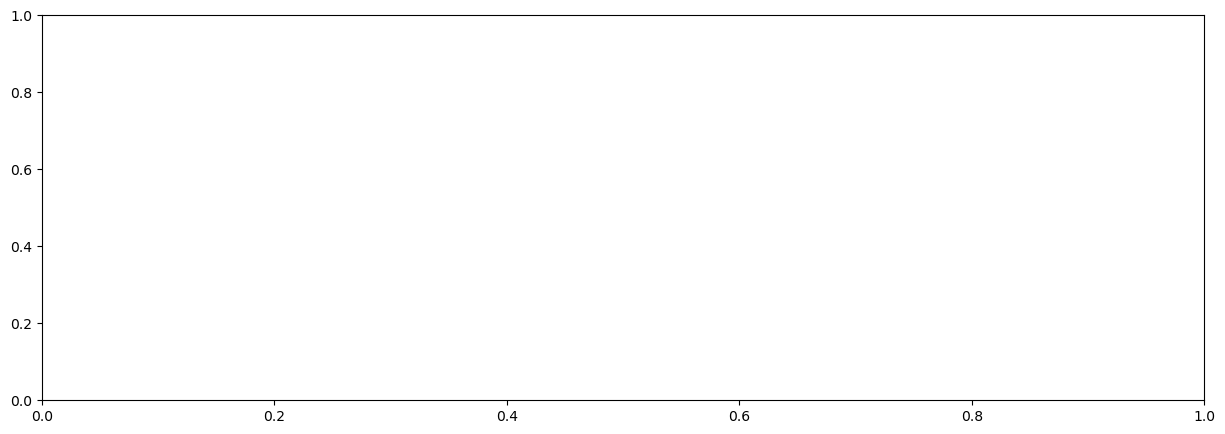

In [55]:
fig, ax1 = plt.subplots(figsize=(15, 5))

In [56]:
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(batch_, train_loss_, 'b-', label='Train')
ax1.plot(batch_, val_loss_, 'b--', label='Validation')
ax1.legend()
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Loss', color='b')
ax1.set_title('Batch Size Vs loss Vs Sensitivity')

Text(0.5, 1.0, 'Batch Size Vs loss Vs Sensitivity')

In [57]:
ax2 = ax1.twinx()
ax2.plot(batch_, sensitivity_, 'r-')
ax2.legend()
ax2.set_ylabel('Sensitivity', color='r')
fig.tight_layout()
fig.savefig(os.path.join(path2write, 'sensitivity_loss.png'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


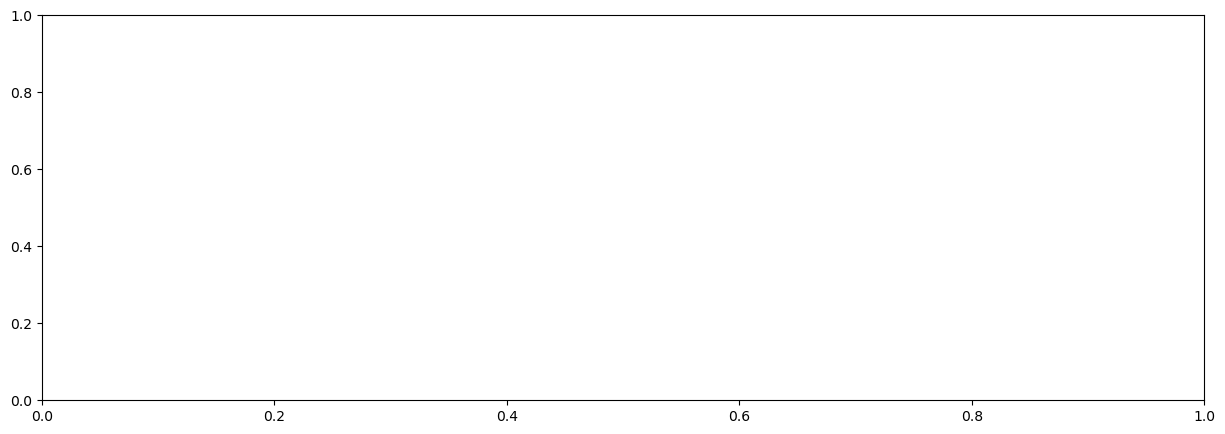

In [58]:
fig, ax1 = plt.subplots(figsize=(15, 5))

In [59]:
ax1 = fig.add_subplot(1, 1, 1)
ax1.plot(batch_, train_acc_, 'b-', label='Train')
ax1.plot(batch_, val_acc_, 'b--', label='Validation')
ax1.legend()
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Accuracy', color='b')
ax1.set_title('Batch Size Vs Accuracy Vs Sensitivity')

Text(0.5, 1.0, 'Batch Size Vs Accuracy Vs Sensitivity')

In [60]:
ax2 = ax1.twinx()
ax2.plot(batch_, sensitivity_, 'r-')
ax2.legend()
ax2.set_ylabel('Sensitivity', color='r')
fig.tight_layout()
fig.savefig(os.path.join(path2write, 'sensitivity_accuracy.png'))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
